# Using DeepExplainer and KernelExplainer for SHAP values

In this notebook we try and calculate SHAP values for our LSTM predictions using `shap.DeepExplainer` (an explainer specifically for deep learning models) and `shap.KernelExplainer` (a model agnostic explainer)

# Set-up

Note: Import of tensorflow needed for DeepExplainer to convert array to tensor. However, this also seems to break the KernelExplainer so we do not import this.

In [1]:
import os

import shap
import pandas as pd
import numpy as np
from keras.models import load_model
# import tensorflow as tf

Using TensorFlow backend.


In [2]:
os.chdir('../..')

In [3]:
from src.models.LSTM.make_predictions import load_retro_data, LSTMPlayerPredictor

In [4]:
pd.options.display.max_columns = None

# Process data

In [5]:
PREVIOUS_GW = 8
PREDICTION_SEASON_ORDER = 4
N_STEPS_IN = 5
COLUMNS_TO_DROP_FOR_TRAINING = ['name', 'season', 'team_name', 'team_name_opponent']

In [6]:
full_data = load_retro_data(current_season_data_filepath='data/gw_player_data/gw_29_player_data.parquet')
print(full_data.shape)
full_data.head()

2020-04-07 19:28:59,833 - Loading raw historical FPL data
2020-04-07 19:28:59,990 - Loaded historical data of shape: (67797, 52)
2020-04-07 19:29:00,040 - Creating season order column
2020-04-07 19:29:00,121 - Generating known features for next GW
2020-04-07 19:29:00,393 - Final input shape: (84295, 68)


(84295, 68)


,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff
0,0,0,1,0,0.1,1,0,0.0,0.2,24,0,0,0,0,4,0,0,0,4,0.0,1,0,0,0,4.5,False,0,aaron_connolly,Brighton & Hove Albion,0,0,2019-20,0,1,0,0,Manchester City,0,1,0,0,1,0,0,0,0,0,0,0,0,0,4,4.5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,0,0.3,1,0,2.2,1.0,6,0,0,0,0,5,0,14029,1,1,21.0,1,10589,13500,2911,4.5,True,0,aaron_connolly,Brighton & Hove Albion,0,0,2019-20,0,1,0,0,Burnley,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,4.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,1,0,4.8,0,0,2.5,2.0,20,0,0,0,0,6,0,22804,0,0,18.0,1,8090,11749,3659,4.5,False,0,aaron_connolly,Brighton & Hove Albion,0,0,2019-20,0,1,0,0,Newcastle United,0,0,1,0,0,1,0,0,0,0,0,0,0,0,4,4.5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,2,0,0.6,1,0,0.1,0.2,25,0,0,0,0,7,0,32699,0,2,0.0,1,8437,13439,5002,4.5,False,0,aaron_connolly,Brighton & Hove Albion,0,0,2019-20,0,1,0,0,Chelsea,0,1,0,0,0,1,0,0,0,0,0,0,0,0,4,4.5,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,3,53,1,23.8,0,2,20.1,70.2,79,0,0,0,0,8,0,35026,0,3,107.0,13,2156,5952,3796,4.5,True,0,aaron_connolly,Brighton & Hove Albion,0,0,2019-20,0,1,0,0,Tottenham Hotspur,0,1,0,1,0,0,1,0,0,0,0,0,0,0,4,4.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Existing prediction methods

In [7]:
lstm_pred = LSTMPlayerPredictor(
    previous_gw=PREVIOUS_GW,
    prediction_season_order=PREDICTION_SEASON_ORDER
)

In [8]:
player_list, player_data_list = lstm_pred.prepare_data_for_lstm(full_data=full_data)

2020-04-07 19:29:00,747 - Number of players available for selection: 39707.0
2020-04-07 19:29:00,816 - Player data shape before: (39707, 68)
2020-04-07 19:29:00,903 - Player data shape after removing players with insufficient GW data: (39674, 68)
2020-04-07 19:29:01,127 - Player data shape after only keeping records needed for LSTM: (2695, 68)


In [9]:
raw_predictions = lstm_pred.make_player_predictions(player_data_list=player_data_list)

2020-04-07 19:29:01,621 - LSTM input array shape: (539, 5, 63)


In [10]:
raw_predictions.head()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum
0,2.077689,2.003415,2.018901,1.961140,1.971908,10.033052
1,2.449217,2.349118,2.338723,2.258069,2.253024,11.648151
2,0.641854,0.643032,0.693726,0.674569,0.703326,3.356508
3,1.944743,1.867459,1.863612,1.792959,1.790690,9.259464
4,2.673024,2.568603,2.563523,2.484003,2.482691,12.771845


In [11]:
final_predictions = lstm_pred.format_predictions(player_list, raw_predictions, full_data)

In [12]:
final_predictions.head()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name,next_match_value
385,5.921670,5.696109,5.706553,5.602526,5.620504,28.547363,mohamed_salah,0,0,0,1,Liverpool,12.4
436,5.740762,5.522748,5.531977,5.429527,5.446103,27.671116,raheem_sterling,0,0,0,1,Manchester City,12.1
305,5.471660,5.263114,5.270849,5.169618,5.184402,26.359642,kevin_de bruyne,0,0,0,1,Manchester City,10.0
479,5.098956,4.902833,4.906946,4.807029,4.818515,24.534279,sergio_agüero,0,1,0,0,Manchester City,12.2
468,4.910195,4.720442,4.722247,4.623315,4.632874,23.609074,sadio_mané,0,0,0,1,Liverpool,11.8


In [13]:
lstm_model = load_model("src/models/pickles/v4_lstm_model.h5")

# DeepExplainer

In [14]:
N_STEPS_IN = 5

input_array = np.concatenate(
    # Make each player player DataFrame into a 3D array
    [df.values.reshape(1, N_STEPS_IN, df.values.shape[1]) for df in player_data_list],
    axis=0
)

input_array.shape

(539, 5, 63)

In [15]:
input_array[:100].shape

(100, 5, 63)

Like `shap.KernelExplainer` we are required to provide a background dataset

In [16]:
background_data = input_array[:100].astype(np.float32)  # Prevent errors due to Booleans

Explainer requires a tensor input

In [17]:
background_data_tensor = tf.convert_to_tensor(background_data)

In [18]:
explainer = shap.DeepExplainer(model=lstm_model, data=background_data_tensor)

keras is no longer supported, please use tf.keras instead.


In [19]:
test_data = input_array[:2].astype(np.float32)  # Data to explain

test_data_tensor = tf.convert_to_tensor(test_data)

In [20]:
shap_values = explainer.shap_values(test_data_tensor)

TypeError: in converted code:

    /Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/shap/explainers/deep/deep_tf.py:239 grad_graph  *
        out = self.model(shap_rAnD)
    /Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:417 symbolic_fn_wrapper  *
        return func(*args, **kwargs)
    /Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/keras/engine/base_layer.py:489 __call__  *
        output = self.call(inputs, **kwargs)
    /Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/keras/engine/network.py:583 call  *
        output_tensors, _, _ = self.run_internal_graph(inputs, masks)
    /Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/keras/engine/network.py:739 run_internal_graph  *
        output_tensors = to_list(
    /Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/keras/layers/recurrent.py:2244 call  *
        return super(LSTM, self).call(inputs,
    /Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/keras/layers/recurrent.py:675 call  *
        last_output, outputs, states = K.rnn(step,
    /Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3104 rnn  *
        reachable = tf_utils.get_reachable_from_inputs([learning_phase()],
    /Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/tensorflow_core/python/keras/utils/tf_utils.py:134 get_reachable_from_inputs
        raise TypeError('Expected Operation, Variable, or Tensor, got ' + str(x))

    TypeError: Expected Operation, Variable, or Tensor, got 0


Looks like a Keras version related issue. Instead of retraining our model using an older version of Keras we instead use a model agnostic explainer.

# KernelExplainer

`shap.KernelExplainer` requires the following:

- Data must take the form of a 2D array
- Data types must all be numeric
    
Our LSTM currently uses a 3D data input `(number of examples, number of time steps, number of features)`. To create a compatible data input shape for KernelExplainer we reshape this such that new columns are created for time steps. Hence the new shape is `(number of examples, number of time steps * number of features)`

We also create a wrapper around the existing prediction method to reconstuct the 2D input array into the 3D array required by LSTM. This allows the same predictions to be made for a lower dimension dataset.

__Example__

In [14]:
player_data_list[0].shape

(5, 63)

In [15]:
player_data_list[0]

,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff
0,0.0,0.0,0.143939,0,0.000745,0.142857,0.0,0.000000,0.001222,0.266667,0,0,0.0,0,0.081081,0.0,0.000000,0.000000,0.571429,0.000000,0.151515,0.566868,0.000000,0.000000,0.071429,False,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0.071429,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.143939,0,0.002234,0.142857,0.0,0.070740,0.006112,0.066667,0,0,0.0,0,0.108108,0.0,0.003812,0.142857,0.142857,0.136364,0.151515,0.572801,0.017205,0.002868,0.071429,True,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.071429,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.143939,0,0.035741,0.000000,0.0,0.080386,0.012225,0.222222,0,0,0.0,0,0.135135,0.0,0.006196,0.000000,0.000000,0.116883,0.151515,0.571401,0.014974,0.003605,0.071429,False,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.071429,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.151515,0,0.004468,0.142857,0.0,0.003215,0.001222,0.277778,0,0,0.0,0,0.162162,0.0,0.008884,0.000000,0.285714,0.000000,0.151515,0.571595,0.017128,0.004928,0.071429,False,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.071429,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.537879,1,0.177215,0.000000,0.5,0.646302,0.429095,0.877778,0,0,0.0,0,0.189189,0.0,0.009516,0.000000,0.428571,0.694805,0.515152,0.568076,0.007586,0.003740,0.071429,True,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0.071429,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
input_data_columns = list(player_data_list[0].columns)

In [17]:
# Order of columns after reshaping to 2D
input_data_columns_flattened = \
    [col + '_minus5' for col in input_data_columns] + \
    [col + '_minus4' for col in input_data_columns] + \
    [col + '_minus3' for col in input_data_columns] + \
    [col + '_minus2' for col in input_data_columns] + \
    [col + '_minus1' for col in input_data_columns]

In [18]:
flattened_df = pd.DataFrame(
    player_data_list[0].values.reshape(1, -1),
    columns=input_data_columns_flattened
)

flattened_df

,assists_minus5,bonus_minus5,bps_minus5,clean_sheets_minus5,creativity_minus5,goals_conceded_minus5,goals_scored_minus5,ict_index_minus5,influence_minus5,minutes_minus5,own_goals_minus5,penalties_missed_minus5,penalties_saved_minus5,red_cards_minus5,gw_minus5,saves_minus5,selected_minus5,team_a_score_minus5,team_h_score_minus5,threat_minus5,total_points_minus5,transfers_balance_minus5,transfers_in_minus5,transfers_out_minus5,value_minus5,was_home_minus5,yellow_cards_minus5,promoted_side_minus5,top_6_last_season_minus5,position_DEF_minus5,position_FWD_minus5,position_GK_minus5,position_MID_minus5,promoted_side_opponent_minus5,top_6_last_season_opponent_minus5,late_kickoff_minus5,early_kickoff_minus5,kickoff_month_Aug_minus5,kickoff_month_Sep_minus5,kickoff_month_Oct_minus5,kickoff_month_Nov_minus5,kickoff_month_Dec_minus5,kickoff_month_Jan_minus5,kickoff_month_Feb_minus5,kickoff_month_Mar_minus5,kickoff_month_Apr_minus5,kickoff_month_May_minus5,next_match_value_minus5,next_match_was_home_minus5,next_match_promoted_side_opponent_minus5,next_match_top_6_last_season_opponent_minus5,next_match_kickoff_month_Aug_minus5,next_match_kickoff_month_Sep_minus5,next_match_kickoff_month_Oct_minus5,next_match_kickoff_month_Nov_minus5,next_match_kickoff_month_Dec_minus5,next_match_kickoff_month_Jan_minus5,next_match_kickoff_month_Feb_minus5,next_match_kickoff_month_Mar_minus5,next_match_kickoff_month_Apr_minus5,next_match_kickoff_month_May_minus5,next_match_late_kickoff_minus5,next_match_early_kickoff_minus5,assists_minus4,bonus_minus4,bps_minus4,clean_sheets_minus4,creativity_minus4,goals_conceded_minus4,goals_scored_minus4,ict_index_minus4,influence_minus4,minutes_minus4,own_goals_minus4,penalties_missed_minus4,penalties_saved_minus4,red_cards_minus4,gw_minus4,saves_minus4,selected_minus4,team_a_score_minus4,team_h_score_minus4,threat_minus4,total_points_minus4,transfers_balance_minus4,transfers_in_minus4,transfers_out_minus4,value_minus4,was_home_minus4,yellow_cards_minus4,promoted_side_minus4,top_6_last_season_minus4,position_DEF_minus4,position_FWD_minus4,position_GK_minus4,position_MID_minus4,promoted_side_opponent_minus4,top_6_last_season_opponent_minus4,late_kickoff_minus4,early_kickoff_minus4,kickoff_month_Aug_minus4,kickoff_month_Sep_minus4,kickoff_month_Oct_minus4,kickoff_month_Nov_minus4,kickoff_month_Dec_minus4,kickoff_month_Jan_minus4,kickoff_month_Feb_minus4,kickoff_month_Mar_minus4,kickoff_month_Apr_minus4,kickoff_month_May_minus4,next_match_value_minus4,next_match_was_home_minus4,next_match_promoted_side_opponent_minus4,next_match_top_6_last_season_opponent_minus4,next_match_kickoff_month_Aug_minus4,next_match_kickoff_month_Sep_minus4,next_match_kickoff_month_Oct_minus4,next_match_kickoff_month_Nov_minus4,next_match_kickoff_month_Dec_minus4,next_match_kickoff_month_Jan_minus4,next_match_kickoff_month_Feb_minus4,next_match_kickoff_month_Mar_minus4,next_match_kickoff_month_Apr_minus4,next_match_kickoff_month_May_minus4,next_match_late_kickoff_minus4,next_match_early_kickoff_minus4,assists_minus3,bonus_minus3,bps_minus3,clean_sheets_minus3,creativity_minus3,goals_conceded_minus3,goals_scored_minus3,ict_index_minus3,influence_minus3,minutes_minus3,own_goals_minus3,penalties_missed_minus3,penalties_saved_minus3,red_cards_minus3,gw_minus3,saves_minus3,selected_minus3,team_a_score_minus3,team_h_score_minus3,threat_minus3,total_points_minus3,transfers_balance_minus3,transfers_in_minus3,transfers_out_minus3,value_minus3,was_home_minus3,yellow_cards_minus3,promoted_side_minus3,top_6_last_season_minus3,position_DEF_minus3,position_FWD_minus3,position_GK_minus3,position_MID_minus3,promoted_side_opponent_minus3,top_6_last_season_opponent_minus3,late_kickoff_minus3,early_kickoff_minus3,kickoff_month_Aug_minus3,kickoff_month_Sep_minus3,kickoff_month_Oct_minus3,kickoff_month_Nov_minus3,kickoff_month_Dec_minus3,kickoff_month_Jan_minus3,kickoff_month_Feb_minus3,kickoff_month_Mar_minus3,kickoff_month_Apr_minus3,kickoff_month_May_minus3,next_mat

In [19]:
reconstructed_df = pd.DataFrame(
    flattened_df.values.reshape(5, -1),
    columns=input_data_columns
)

reconstructed_df

,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff
0,0,0,0.143939,0,0.000744602,0.142857,0,0,0.00122249,0.266667,0,0,0,0,0.0810811,0,0,0,0.571429,0,0.151515,0.566868,0,0,0.0714286,False,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0.0714286,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0.143939,0,0.0022338,0.142857,0,0.0707395,0.00611247,0.0666667,0,0,0,0,0.108108,0,0.00381165,0.142857,0.142857,0.136364,0.151515,0.572801,0.0172053,0.00286804,0.0714286,True,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0714286,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,0,0,0.143939,0,0.0357409,0,0,0.0803859,0.0122249,0.222222,0,0,0,0,0.135135,0,0.0061958,0,0,0.116883,0.151515,0.571401,0.0149737,0.003605,0.0714286,False,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.0714286,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0.151515,0,0.00446761,0.142857,0,0.00321543,0.00122249,0.277778,0,0,0,0,0.162162,0,0.00888425,0,0.285714,0,0.151515,0.571595,0.0171276,0.00492818,0.0714286,False,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.0714286,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1
4,0,1,0.537879,1,0.177215,0,0.5,0.646302,0.429095,0.877778,0,0,0,0,0.189189,0,0.00951649,0,0.428571,0.694805,0.515152,0.568076,0.00758564,0.00373998,0.0714286,True,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0.0714286,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [20]:
# Check reconstructed data:
for col in input_data_columns:
    np.testing.assert_array_equal(
        player_data_list[0][col],
        reconstructed_df[col]
    )

__Create input array for LSTM by doing above steps for all DataFrames in `player_data_list`__

In [21]:
player_data_flattened_list = [
    pd.DataFrame(
        df.values.reshape(1, -1),
        columns=input_data_columns_flattened
    ) 
    for df in player_data_list
]

player_data_flattened_df = pd.concat(player_data_flattened_list, ignore_index=True)
print(player_data_flattened_df.shape)
player_data_flattened_df.head()

(539, 315)


,assists_minus5,bonus_minus5,bps_minus5,clean_sheets_minus5,creativity_minus5,goals_conceded_minus5,goals_scored_minus5,ict_index_minus5,influence_minus5,minutes_minus5,own_goals_minus5,penalties_missed_minus5,penalties_saved_minus5,red_cards_minus5,gw_minus5,saves_minus5,selected_minus5,team_a_score_minus5,team_h_score_minus5,threat_minus5,total_points_minus5,transfers_balance_minus5,transfers_in_minus5,transfers_out_minus5,value_minus5,was_home_minus5,yellow_cards_minus5,promoted_side_minus5,top_6_last_season_minus5,position_DEF_minus5,position_FWD_minus5,position_GK_minus5,position_MID_minus5,promoted_side_opponent_minus5,top_6_last_season_opponent_minus5,late_kickoff_minus5,early_kickoff_minus5,kickoff_month_Aug_minus5,kickoff_month_Sep_minus5,kickoff_month_Oct_minus5,kickoff_month_Nov_minus5,kickoff_month_Dec_minus5,kickoff_month_Jan_minus5,kickoff_month_Feb_minus5,kickoff_month_Mar_minus5,kickoff_month_Apr_minus5,kickoff_month_May_minus5,next_match_value_minus5,next_match_was_home_minus5,next_match_promoted_side_opponent_minus5,next_match_top_6_last_season_opponent_minus5,next_match_kickoff_month_Aug_minus5,next_match_kickoff_month_Sep_minus5,next_match_kickoff_month_Oct_minus5,next_match_kickoff_month_Nov_minus5,next_match_kickoff_month_Dec_minus5,next_match_kickoff_month_Jan_minus5,next_match_kickoff_month_Feb_minus5,next_match_kickoff_month_Mar_minus5,next_match_kickoff_month_Apr_minus5,next_match_kickoff_month_May_minus5,next_match_late_kickoff_minus5,next_match_early_kickoff_minus5,assists_minus4,bonus_minus4,bps_minus4,clean_sheets_minus4,creativity_minus4,goals_conceded_minus4,goals_scored_minus4,ict_index_minus4,influence_minus4,minutes_minus4,own_goals_minus4,penalties_missed_minus4,penalties_saved_minus4,red_cards_minus4,gw_minus4,saves_minus4,selected_minus4,team_a_score_minus4,team_h_score_minus4,threat_minus4,total_points_minus4,transfers_balance_minus4,transfers_in_minus4,transfers_out_minus4,value_minus4,was_home_minus4,yellow_cards_minus4,promoted_side_minus4,top_6_last_season_minus4,position_DEF_minus4,position_FWD_minus4,position_GK_minus4,position_MID_minus4,promoted_side_opponent_minus4,top_6_last_season_opponent_minus4,late_kickoff_minus4,early_kickoff_minus4,kickoff_month_Aug_minus4,kickoff_month_Sep_minus4,kickoff_month_Oct_minus4,kickoff_month_Nov_minus4,kickoff_month_Dec_minus4,kickoff_month_Jan_minus4,kickoff_month_Feb_minus4,kickoff_month_Mar_minus4,kickoff_month_Apr_minus4,kickoff_month_May_minus4,next_match_value_minus4,next_match_was_home_minus4,next_match_promoted_side_opponent_minus4,next_match_top_6_last_season_opponent_minus4,next_match_kickoff_month_Aug_minus4,next_match_kickoff_month_Sep_minus4,next_match_kickoff_month_Oct_minus4,next_match_kickoff_month_Nov_minus4,next_match_kickoff_month_Dec_minus4,next_match_kickoff_month_Jan_minus4,next_match_kickoff_month_Feb_minus4,next_match_kickoff_month_Mar_minus4,next_match_kickoff_month_Apr_minus4,next_match_kickoff_month_May_minus4,next_match_late_kickoff_minus4,next_match_early_kickoff_minus4,assists_minus3,bonus_minus3,bps_minus3,clean_sheets_minus3,creativity_minus3,goals_conceded_minus3,goals_scored_minus3,ict_index_minus3,influence_minus3,minutes_minus3,own_goals_minus3,penalties_missed_minus3,penalties_saved_minus3,red_cards_minus3,gw_minus3,saves_minus3,selected_minus3,team_a_score_minus3,team_h_score_minus3,threat_minus3,total_points_minus3,transfers_balance_minus3,transfers_in_minus3,transfers_out_minus3,value_minus3,was_home_minus3,yellow_cards_minus3,promoted_side_minus3,top_6_last_season_minus3,position_DEF_minus3,position_FWD_minus3,position_GK_minus3,position_MID_minus3,promoted_side_opponent_minus3,top_6_last_season_opponent_minus3,late_kickoff_minus3,early_kickoff_minus3,kickoff_month_Aug_minus3,kickoff_month_Sep_minus3,kickoff_month_Oct_minus3,kickoff_month_Nov_minus3,kickoff_month_Dec_minus3,kickoff_month_Jan_minus3,kickoff_month_Feb_minus3,kickoff_month_Mar_minus3,kickoff_month_Apr_minus3,kickoff_month_May_minus3,next_mat

In [22]:
# Array passed to SHAP functions
lstm_input_array = player_data_flattened_df.values

__Check reconstruction of data from `lstm_input_array`__

In [23]:
player_data_list_reconstructed_test = [
    pd.DataFrame(
        input_array.reshape(5, -1),
        columns=input_data_columns
    ) 
    for input_array 
    in np.array_split(  # Split array into individual flat row arrays
        lstm_input_array,
        lstm_input_array.shape[0]
    )
]

In [24]:
len(player_data_list_reconstructed_test)

539

In [25]:
# Check reconstructed data
reconstructed_concat = pd.concat(player_data_list_reconstructed_test, ignore_index=True)
original_concat = pd.concat(player_data_list, ignore_index=True)

for col in input_data_columns:
    np.testing.assert_array_equal(
        reconstructed_concat[col],
        original_concat[col]
    )

__Create wrapper function around `lstm_pred.make_player_predictions`__

In [26]:
def make_predictions(input_array_2d):
    """
    Wrapper around make_player_predictions which includes the additional step of converting the 2D input array to a list of 3D arrays for each player.
    """
    # 2D input array to list of 3D arrays:
    player_data_list_reconstructed = [
        pd.DataFrame(
            input_array.reshape(5, -1),
            columns=input_data_columns
        ) 
        for input_array 
        in np.array_split(
            input_array_2d,
            input_array_2d.shape[0]
        )
    ]
    
    # Make predictions:
    raw_predictions = lstm_pred.make_player_predictions(
        player_data_list=player_data_list_reconstructed
    )
    
    return raw_predictions['GW_plus_1']

In [27]:
# Test function
make_predictions(lstm_input_array)

2020-04-07 19:29:23,900 - LSTM input array shape: (539, 5, 63)


0      2.077689
1      2.449217
2      0.641854
3      1.944743
4      2.673024
         ...   
534    0.506600
535    2.894003
536    0.559625
537    2.360749
538    0.071585
Name: GW_plus_1, Length: 539, dtype: float32

In [28]:
lstm_input_array.shape

(539, 315)

In [30]:
lstm_input_array

array([[0.0, 0.0, 0.14393939393939392, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.13636363636363635, ..., 0.0, 0.0, 1.0],
       [0.0, 0.0, 0.1893939393939394, ..., 0.0, 0.0, 0.0],
       ...,
       [0.0, 0.0, 0.13636363636363635, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.30303030303030304, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.13636363636363635, ..., 0.0, 0.0, 0.0]], dtype=object)

In [33]:
idx = np.random.randint(lstm_input_array.shape[0], size=100)  # Use 100 random examples in background data
idx

array([445, 302, 417, 238, 145, 159,  98, 136, 481, 497,  74, 157, 391,
        93, 336, 382, 490, 462, 109, 364, 392, 382, 139, 169, 460, 320,
       225,   5, 182, 204, 429, 427, 314, 321, 135, 528, 533, 538, 531,
       265, 156, 473, 170, 329,  48, 462, 144, 377, 385, 351, 310, 537,
       207, 288,  64, 394, 112, 414, 309, 173, 310, 421, 210,  87, 212,
       416, 111, 144, 384, 245, 107, 384, 424,  99, 276, 155, 375, 371,
       265,  90, 139, 131, 517, 156, 528, 255, 177,  42, 399, 211, 338,
       492, 496, 315, 298, 368,  43, 228, 367, 222])

In [36]:
background_data = lstm_input_array[idx, :]
background_data.shape

(100, 315)

In [37]:
explainer = shap.KernelExplainer(make_predictions, background_data.astype(np.float32))

2020-04-07 19:33:03,109 - LSTM input array shape: (100, 5, 63)


In [38]:
# Turn off logs
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [43]:
idx_shap = np.random.randint(lstm_input_array.shape[0], size=50)  # Use 50 random examples to get SHAP values for
test_data = lstm_input_array[idx_shap, :]
test_data.shape

(50, 315)

In [44]:
%%time
shap_values = explainer.shap_values(test_data.astype(np.float32))

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


CPU times: user 1h 1min 21s, sys: 3min 44s, total: 1h 5min 6s
Wall time: 51min 50s


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [45]:
shap_values

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00251107, -0.00292878,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00134776,  0.        , -0.00206944, ...,  0.        ,
         0.        ,  0.        ]])

In [46]:
# import pickle

In [47]:
# with open("shap_stuff.pickle", "wb") as f:
#     pickle.dump((shap_values, input_data_columns_flattened), f)

In [48]:
# from src.models.utils import _load_model_from_pickle

In [49]:
# test = _load_model_from_pickle("shap_stuff.pickle")

In [5]:
# shap_values = test[0]
# input_data_columns_flattened = test[1]

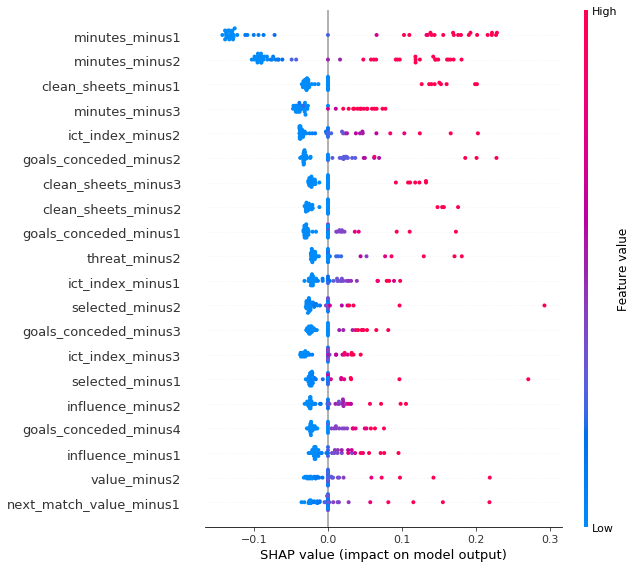

In [53]:
shap.summary_plot(
    shap_values,
    features=test_data.astype(np.float32),
    feature_names=input_data_columns_flattened
)

In [55]:
raw_predictions['name'] = player_list
raw_predictions.head()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name
0,2.077689,2.003415,2.018901,1.961140,1.971908,10.033052,aaron_connolly
1,2.449217,2.349118,2.338723,2.258069,2.253024,11.648151,aaron_cresswell
2,0.641854,0.643032,0.693726,0.674569,0.703326,3.356508,aaron_lennon
3,1.944743,1.867459,1.863612,1.792959,1.790690,9.259464,aaron_mooy
4,2.673024,2.568603,2.563523,2.484003,2.482691,12.771845,aaron_ramsdale


In [59]:
raw_predictions.loc[idx_shap, :].sort_values('GW_plus_1', ascending=False).head()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name
436,5.740762,5.522748,5.531977,5.429527,5.446103,27.671116,raheem_sterling
445,3.565508,3.421891,3.412213,3.319491,3.317965,17.037069,richarlison_de andrade
494,3.544166,3.398824,3.387402,3.293994,3.291589,16.915974,sébastien_haller
130,3.073580,2.948062,2.934186,2.844538,2.838944,14.639310,david_luiz moreira marinho
403,2.949780,2.829145,2.814409,2.725301,2.718702,14.037336,nick_pope


In [62]:
for i, idx in enumerate(idx_shap):
    if idx == 436:  # Raheem Sterling
        print(i)

4


In [64]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[4,:], lstm_input_array[436].astype(np.float32), feature_names=input_data_columns_flattened)

In [65]:
pd.DataFrame(shap_values, columns=input_data_columns_flattened).iloc[4].sort_values(ascending=False)

selected_minus2                        0.292699
selected_minus1                        0.270836
selected_minus3                        0.263395
value_minus2                           0.218780
next_match_value_minus1                0.218339
                                         ...   
next_match_kickoff_month_May_minus3    0.000000
next_match_kickoff_month_Apr_minus3    0.000000
next_match_kickoff_month_Mar_minus3    0.000000
next_match_kickoff_month_Feb_minus3    0.000000
assists_minus5                         0.000000
Name: 4, Length: 315, dtype: float64

__Try for a GK:__

In [66]:
for i, idx in enumerate(idx_shap):
    if idx == 403:  # Nick Pope
        print(i)

35


In [67]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[35,:], lstm_input_array[403].astype(np.float32), feature_names=input_data_columns_flattened)

In [68]:
pd.DataFrame(shap_values, columns=input_data_columns_flattened).iloc[35].sort_values(ascending=False)

minutes_minus1                                  0.179815
minutes_minus2                                  0.149094
clean_sheets_minus1                             0.144230
clean_sheets_minus3                             0.111093
selected_minus2                                 0.096794
                                                  ...   
penalties_saved_minus2                          0.000000
red_cards_minus2                                0.000000
gw_minus2                                       0.000000
assists_minus5                                  0.000000
next_match_top_6_last_season_opponent_minus4   -0.000013
Name: 35, Length: 315, dtype: float64

# Next steps

- Have a means of using KernelExplainer to get SHAP values
- Can integrate within interface to get most important features for a given player prediction
- Need to choose a sensible background dataset
- Need to clarify what numbers in above plot are - why are they different to SHAP values despite ordering being the same? Something to do with `expected_value`?
- Explore what most important features are for highest ranked, mid-ranked etc.
- Should be done on future model training to check for overfitting